<a href="https://colab.research.google.com/github/DimaUd/Heart-Attack/blob/main/Heart_Attack_Part2_DataPrepararation_and_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Importing Libraries and Dataset-יבוא ספריות ונתונים להבנת הנתונים

In [1]:
#Importing Libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_style('darkgrid')
pd.options.mode.chained_assignment = None
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_columns', 40)
pd.set_option('display.width', 600)
%matplotlib inline 


from sklearn.compose  import ColumnTransformer #column subsets  that transformed separately and the features generated by each transformer will be concatenated to form a single feature space. 
from sklearn.pipeline import Pipeline #Pipeline is used to assemble several steps that can be cross-validated together while setting different parameters.
from sklearn.preprocessing import  StandardScaler, OneHotEncoder, RobustScaler,OrdinalEncoder,MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score,plot_confusion_matrix,f1_score
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

### Reading The Clean Data from part1

In [2]:
# Dataset on my github-page
url='https://github.com/DimaUd/Heart-Attack-/blob/main/heart_clean_data.csv?raw=true'
heart_clean_data=pd.read_csv(url)
display(heart_clean_data.head())

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.30,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.50,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.40,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.80,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.60,2,0,2,1


#Data Preparation


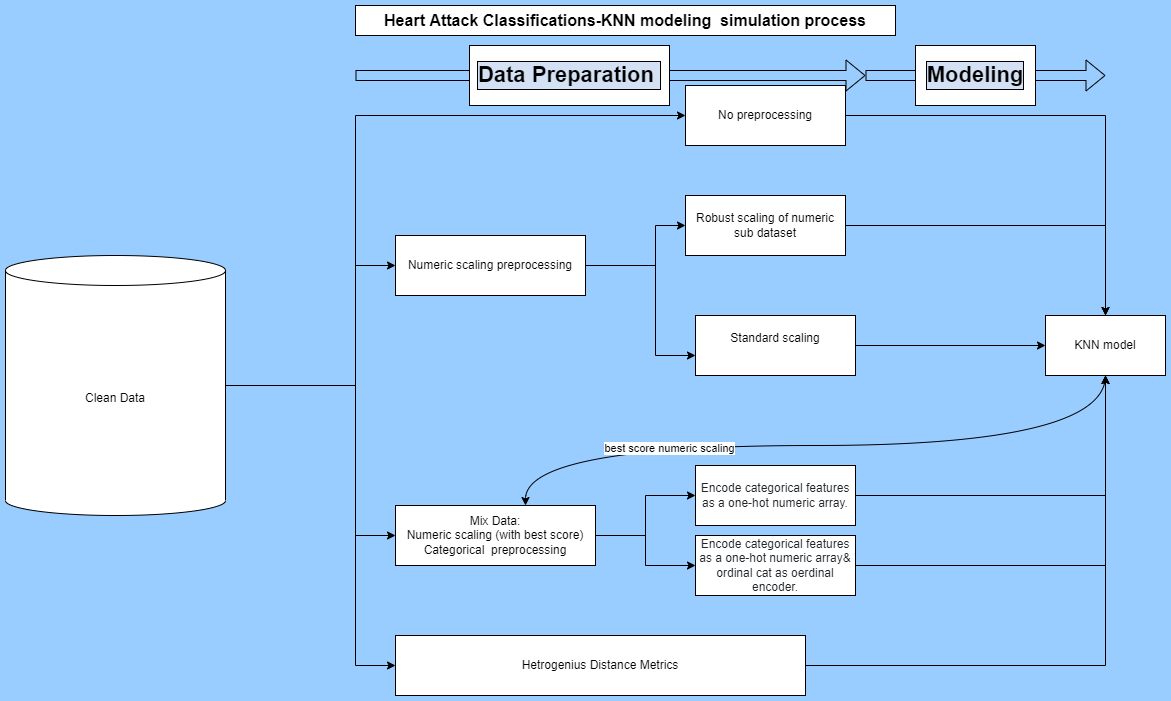


https://drive.google.com/file/d/1x_L2N8UAmTIRvZQmDV9xmn7il7rVhZ5A/view?usp=sharing

######כעת אחרי הבנה עסקית כולל הגדרת שאלה 
######ואחרי חקירה וניקוי נתונים אפשר לעבור לשלב 
######הכנת נתונים לטובת בניית אלגוריתמים שיאפשרו
######לפתור בעיה עסקית, במקרה שלנו על פי מספר פרמטרים 
######לזהות אדם עם סיכוי גבוהה יותר ליתקף לב 
 *KNN במדירך זה תוך כדי הסבר אציג הכנת נתונים עבור אלגוריתם*
#####.כדי להכין נתונים עבור אלגוריתם חשוב להבין עקרון עבודתו
#####,K-מבוסס על בחירת כמות שכנים KNN 
##### איזוגי K כאשר מספר מחלקות זוגי נכון לבחור  מספר 
#####  מכיוון שהחלטת שיוך תצפית למחלקה מסוימת מטבצעת 
#####על פי שיוך של רוב שכנים הקרובים לתצפית שאותה מנסים לשייך למחלקה
##### על בסיס מדדי קירבה שונים נוכל לבחור תצפיות רלונטיות
##### KNN בהרחבה יתרה ניתן [ לעיין במסמך על](https://docs.google.com/document/d/1f1AezrCGfuBdZ6Xi_jfTCAp-USfMQc09oc17YMyojYs/edit?usp=sharing) 

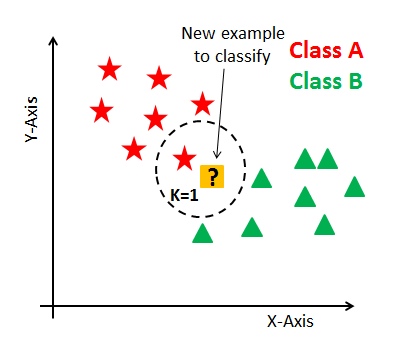

*:שלבי עבודה של אלגוריתם*
* K קביעת מספר שכנים הקרובים 
* בחירת שכנים הקרובים 
* ספירת מספר שכנים לפי מחלקות 
* סיווג תצפית למחקלה השכיחה


##Scaling and encoding dataset

In [3]:
categorical_features  =[]
numeric_features  =[]
for column in heart_clean_data.drop(['output'],axis=1).columns:  
    if len(heart_clean_data[column].unique())<=10:
        categorical_features.append(column)
    else:numeric_features .append(column)  
print('______Categorical Columns____________')
print(categorical_features )  
print('________Continuous Columns____________')
print(numeric_features )

______Categorical Columns____________
['sex', 'cp', 'fbs', 'restecg', 'exng', 'slp', 'caa', 'thall']
________Continuous Columns____________
['age', 'trtbps', 'chol', 'thalachh', 'oldpeak']



##### Feature Engineering בשלב זה אנחנו עוסקים בטרנספורמציה והנדסת משתנים 
#####חשוב תציין שבמקרה זה יש מספר תרחישים שבהם ניתן  לפעול
##### בהנתן לצורה שבה  נגדיר נתונים לפי סוג נתון נצטרך להתאים שיטת טרנספורמציה
##### .כדי  שנוכל להפיק מקסימום מידע היכרחי ולהתאים מודל אמין ומדויק
##### כמובן שכל אחד יכול להתאים אין סוף גישות ואין סוף שיטות כאן זה רק הצעה אחת מן הרבים האפשריים 
##### כמשתנים סידוריים slp & caa כך למשל ניתן להגדיר את המשתנים
##### ואז נצטרך להתאים שיטת טרנספוקמציה שמתחשבת בעובדה זו
##### בנוסף אנחנו צריכים להפוך את המשתנים קטגורליים לבנאריים
##### במקרה שלנו מכיוון שעל בסיס ידע שיש לי בנושא הפרויקט
#####  (ערכי קטגוריות הם סימטריים (לפחות זו היא ההנחה לפרויקט זה
##### אלגוריתם הנבחן יודע לעבוד רק עם ערכים מספריים
##### *(בנוי על בחינת מרחק בין התצפיות במרחב  KNN)*
##### ולכן יש חשיבות רבה איך ובין מה אנחנו מודדים את המרחק
##### אשר מושפע במידה רבה מכל משתנה שאנחנו מתחשבים 
#####  בו במטרה לבדוק מרחק בין התצפיות
##### בנוסף מאד חשוב להפוך את הסכלה של משתנים רציפים 
##### כדי למנוע השפעה לא פרופורציונאלית של משתנים אלו
##### כדי להדגים השפעה של הדברים אלו בחרתי לעשות הדגמה
##### TrainingScore מדורגת של שיטות טרנספורמציה על ציון אימון של המודל  


#### No preprocessing

In [4]:
heart_data_prep=heart_clean_data.copy()# לוקח רק נתונים רציפים מכיוון שנתונים קטגורליים לא רלונטיים בכלל לאלגוריתם ללא טרנספורמציה
print(f'heart_data_noprep Example: \n{heart_clean_data[numeric_features].head(1)}')
X=heart_clean_data[numeric_features]
y=heart_clean_data['output']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
grid_params={
    'n_neighbors':range(2,40),
    'weights':['uniform','distance'],
    'metric':['euclidean','manhattan','minkowski']

}
gs=GridSearchCV(
    KNeighborsClassifier(),
    grid_params,
    verbose=1,
    cv=10,
    n_jobs=-1,
    return_train_score=True
)

gs_knn_result=gs.fit(X_train,y_train)
print(f'Best training score:{round(gs_knn_result.best_score_,3)*100}') #~Best training score:70.1
print(f'Best parametrs:{gs_knn_result.best_params_}')

y_pred=gs.predict(X_test)
print(f'Test Accuracy:{round(accuracy_score(y_pred,y_test),3)*100}')
cf_matrix=confusion_matrix(y_test,y_pred)


heart_data_noprep Example: 
   age  trtbps  chol  thalachh  oldpeak
0   63     145   233       150     2.30
Fitting 10 folds for each of 228 candidates, totalling 2280 fits
Best training score:70.1
Best parametrs:{'metric': 'manhattan', 'n_neighbors': 22, 'weights': 'distance'}
Test Accuracy:70.5


##### ניתן לראות שאנחנו מקבלים תוצאה של כ-70% דיוק ללא כל הכנה של הנתונים 
##### שזה כמובן לא משהוא שיכול לשרת מטרה עסקית שלנו במיוחד כאשר מדובר בנתונים רפואים

#### Numeric Scalling - Robusting 

In [5]:
heart_data_prep=heart_clean_data.copy()# לוקח רק נתונים רציפים מכיוון שנתונים קטגורליים לא רלונטיים בכלל לאלגוריתם ללא טרנספורמציה
print(f'heart_data_noprep Example: \n{heart_clean_data[numeric_features][:1]}')
X=heart_clean_data[numeric_features]
y=heart_clean_data['output']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Robust scaling of numeric sub dataset
robust_scaler= RobustScaler()
X_train=robust_scaler.fit_transform(X_train)
X_test=robust_scaler.transform(X_test)


grid_params={
    'n_neighbors':range(2,40),
    'weights':['uniform','distance'],
    'metric':['euclidean','manhattan','minkowski']

}
gs=GridSearchCV(
    KNeighborsClassifier(),
    grid_params,
    verbose=1,
    cv=10,
    n_jobs=-1,
    return_train_score=True
)


gs_knn_result=gs.fit(X_train,y_train)
print(f'Best training score:{round(gs_knn_result.best_score_,3)*100}') #~Best training score:72.2
print(f'Best parametrs:{gs_knn_result.best_params_}')

y_pred=gs.predict(X_test)
print(f'Test Accuracy:{round(accuracy_score(y_pred,y_test),3)*100}')

heart_data_noprep Example: 
   age  trtbps  chol  thalachh  oldpeak
0   63     145   233       150     2.30
Fitting 10 folds for each of 228 candidates, totalling 2280 fits
Best training score:72.2
Best parametrs:{'metric': 'euclidean', 'n_neighbors': 31, 'weights': 'distance'}
Test Accuracy:75.4


##### נבע מהעובדה שיש ערכים קיצוניים בחלק ממשתנים רציפים RobustScaling רעיון להישתמש ב
######    אפשר לזהות שיפור קל בתוצאה RobustScaling אחרי שימוש ב  

#### Numeric Scalling - Standard Scaling 

In [6]:
heart_data_prep=heart_clean_data.copy()# לוקח רק נתונים רציפים מכיוון שנתונים קטגורליים לא רלונטיים בכלל לאלגוריתם ללא טרנספורמציה
print(f'heart_data_noprep Example: \n{heart_clean_data[numeric_features][:1]}')
X=heart_clean_data[numeric_features]
y=heart_clean_data['output']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Standard scaling of numeric sub dataset
standard_scaler= StandardScaler()
X_train=standard_scaler.fit_transform(X_train)
X_test=standard_scaler.transform(X_test)


grid_params={
    'n_neighbors':range(2,40),
    'weights':['uniform','distance'],
    'metric':['euclidean','manhattan','minkowski']

}
gs=GridSearchCV(
    KNeighborsClassifier(),
    grid_params,
    verbose=1,
    cv=10,
    n_jobs=-1,
    return_train_score=True
)

gs_knn_result=gs.fit(X_train,y_train)
print(f'Best training score:{round(gs_knn_result.best_score_,3)*100}') #Best training score:72.6
print(f'Best parametrs:{gs_knn_result.best_params_}')

y_pred=gs.predict(X_test)
print(f'Test Accuracy:{round(accuracy_score(y_pred,y_test),3)*100}')

heart_data_noprep Example: 
   age  trtbps  chol  thalachh  oldpeak
0   63     145   233       150     2.30
Fitting 10 folds for each of 228 candidates, totalling 2280 fits
Best training score:72.6
Best parametrs:{'metric': 'manhattan', 'n_neighbors': 32, 'weights': 'uniform'}
Test Accuracy:75.4


#####ניתן לראות שיפור מסוים בתוצאה  standard scaler במקרה של 
#####הוא הגבוהה Best training score  ובנוסף חשוב לציין ש
#####ולכן על פי [התיכנון שלי](https://colab.research.google.com/drive/1yXJYPkrqQ2PV5MCraSXhcYKvQMWJloxt#scrollTo=gyXMMK1y2-J9&line=5&uniqifier=1) אשתמש בטרנספורמר זה עבור משתנים רציפים

Mix Data: numeric and categorical preprossesing

In [10]:
numeric_transformer =Pipeline(steps=[('scaler',StandardScaler())])
categorical_transformer=Pipeline(steps=[('onehot',OneHotEncoder(handle_unknown='ignore'))])
prep=ColumnTransformer(transformers=[('num',numeric_transformer,numeric_features ),
                                     ('cat',categorical_transformer,categorical_features)])

heart_data_prep=heart_clean_data.copy()
print("OrigDataset",heart_data_prep.head(1))
X=heart_data_prep.drop('output',axis=1)
print("X - columns:",X.columns)
y=heart_data_prep['output']
print("y-target name:",y.name)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train=prep.fit_transform(X_train)
X_test=prep.transform(X_test)

print('------example of X_train after preperations---------\n',X_train[:1])


grid_params={
    'n_neighbors':range(2,40),
    'weights':['uniform','distance'],
    'metric':['euclidean','manhattan','minkowski']

}
gs=GridSearchCV(
    KNeighborsClassifier(),
    grid_params,verbose=1,
    cv=10,
    n_jobs=-1
)


gs_knn_result=gs.fit(X_train,y_train)
print(f'Best training score:{round(gs_knn_result.best_score_,3)*100}') #~Best training score:85.1
print(f'Best parametrs:{gs_knn_result.best_params_}')

y_pred=gs.predict(X_test)
print(f'Test Accuracy:{round(accuracy_score(y_pred,y_test),3)*100}')

OrigDataset    age  sex  cp  trtbps  chol  fbs  restecg  thalachh  exng  oldpeak  slp  caa  thall  output
0   63    1   3     145   233    1        0       150     0     2.30    0    0      1       1
X - columns: Index(['age', 'sex', 'cp', 'trtbps', 'chol', 'fbs', 'restecg', 'thalachh', 'exng', 'oldpeak', 'slp', 'caa', 'thall'], dtype='object')
y-target name: output
------example of X_train after preperations---------
 [[-1.350641   -0.63071093  0.92713761  0.54913872 -0.89583663  0.
   1.          0.          1.          0.          0.          1.
   0.          0.          1.          0.          1.          0.
   0.          0.          1.          1.          0.          0.
   0.          0.          1.          0.        ]]
Fitting 10 folds for each of 228 candidates, totalling 2280 fits
Best training score:85.1
Best parametrs:{'metric': 'manhattan', 'n_neighbors': 6, 'weights': 'distance'}
Test Accuracy:85.2


####Transform Ordinal cat as OrdinalEncoder

In [11]:
numeric_transformer =Pipeline(steps=[('scaler',StandardScaler())])
categorical_transformer=Pipeline(steps=[('onehot',OneHotEncoder(handle_unknown='ignore'))])
categorical_ordinal_transformer=Pipeline(steps=[('ordinal',OrdinalEncoder())])

prep=ColumnTransformer(transformers=[('num',numeric_transformer,numeric_features ),
                                     ('cat',categorical_transformer,['sex', 'cp', 'fbs', 'restecg', 'exng',  'thall']),
                                     ('cat_ord',categorical_ordinal_transformer,['slp', 'caa']) ])

heart_data_prep=heart_clean_data.copy()
print("OrigDataset",heart_data_prep.head(1))
X=heart_data_prep.drop('output',axis=1)
print("X - columns:",X.columns)
y=heart_data_prep['output']
print("y-target name:",y.name)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train=prep.fit_transform(X_train)
X_test=prep.transform(X_test)

print('------example of X_train after preperations---------\n',X_train[:1])


grid_params={
    'n_neighbors':range(2,40),
    'weights':['uniform','distance'],
    'metric':['euclidean','manhattan','minkowski']

}
gs=GridSearchCV(
    KNeighborsClassifier(),
    grid_params,verbose=1,
    cv=10,
    n_jobs=-1
)


gs_knn_result=gs.fit(X_train,y_train)
print(f'Best training score:{round(gs_knn_result.best_score_,3)*100}') #~Best training score:83.8
print(f'Best parametrs:{gs_knn_result.best_params_}')

y_pred=gs.predict(X_test)
print(f'Test Accuracy:{round(accuracy_score(y_pred,y_test),3)*100}')

OrigDataset    age  sex  cp  trtbps  chol  fbs  restecg  thalachh  exng  oldpeak  slp  caa  thall  output
0   63    1   3     145   233    1        0       150     0     2.30    0    0      1       1
X - columns: Index(['age', 'sex', 'cp', 'trtbps', 'chol', 'fbs', 'restecg', 'thalachh', 'exng', 'oldpeak', 'slp', 'caa', 'thall'], dtype='object')
y-target name: output
------example of X_train after preperations---------
 [[-1.350641   -0.63071093  0.92713761  0.54913872 -0.89583663  0.
   1.          0.          1.          0.          0.          1.
   0.          0.          1.          0.          1.          0.
   0.          1.          0.          2.          0.        ]]
Fitting 10 folds for each of 228 candidates, totalling 2280 fits
Best training score:84.6
Best parametrs:{'metric': 'manhattan', 'n_neighbors': 26, 'weights': 'distance'}
Test Accuracy:85.2
